Parameter inference
============

Let's start to import the necessary classes. We also set up matplotlib and we're going to use pandas as well.

In [1]:
import pyabc

import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Our model is about as simple as it gets. We assume a Gaussian model $\mathcal{N}(\mathrm{mean}, 0.5^2)$ with the single parameter $\mathrm{mean}$. The variance is $0.5^2$.
In this case, the parameter dictionary that is passed to the model has only the single key `mean`. We name the sampled data just `data`. It might look like overcomplicating things to return a whole dictionary, but as soon as we return heterogeneous data this starts to make a lot of sense.

In [2]:
def model(parameter):
    return {"data": parameter["mean"] + 0.5 * sp.randn()}

We then define the prior for the `mean` to be uniform over the interval $[0, 5]$:

In [3]:
prior = pyabc.Distribution(mean=pyabc.RV("uniform", 0, 5))

(Actually, this has to be read as $[0, 0+5]$. For example, `RV("uniform", 1, 5)` is uniform over the interval $[1,6]$. Check the `scipy.stats` package for details of the definition.)

We also need to specify when we consider data to be close in form of a distance funtion.
We just take the absolute value of the difference here.

In [4]:
def distance(x, y):
    return abs(x["data"] - y["data"])

Now we create the `ABCSMC` object, passing the model, the prior and the distance to it.

In [5]:
abc = pyabc.ABCSMC(model, prior, distance)

To get going, we have to specify where to log the ABC-SMC runs.

Usually you would now have some measure data which you want to know the posterior of.
Here, we just assume, that the measured data was 2.5.

In [6]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
observation = 2.5
abc.new(db_path, {"data": observation})

INFO:History:Start <ABCSMC(id=6, start_time=2019-03-24 18:48:15.644727, end_time=None)>
INFO:Epsilon:initial epsilon is 1.2026360337417659


6

The `new` method returned an integer. This is the id of the ABC-SMC run.
This id is only important if more than one ABC-SMC run is stored in the same database.

Let's start the sampling now. We'll sample until the acceptance threshold epsilon drops below 0.2. We also specify that we want a maximum number of 10 populations.
So whatever is reached first, `minimum_epsilon` or `max_nr_populations`, will stop further sampling.

For the simple model we defined above, this should only take a couple of seconds:

In [7]:
history = abc.run(minimum_epsilon=.05, max_nr_populations=10)

INFO:ABC:t:0 eps:1.2026360337417659
INFO:ABC:t:1 eps:0.5086742442976572
INFO:ABC:t:2 eps:0.3047326519177156
INFO:ABC:t:3 eps:0.16267476153717844
INFO:ABC:t:4 eps:0.08698426846049073
INFO:ABC:t:5 eps:0.03792727934617782
INFO:History:Done <ABCSMC(id=6, start_time=2019-03-24 18:48:15.644727, end_time=2019-03-24 18:49:49.441576)>


In [8]:
history is abc.history

True

Now we visualize the probability density functions.
The vertical line indicates the location of the observation.
Given our model, we expect the mean to be close to the observed data.

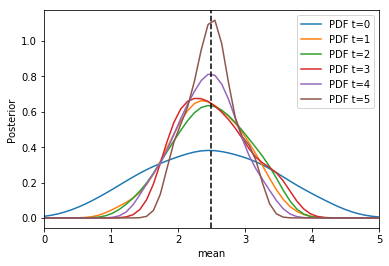

In [9]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=5,
        x="mean", ax=ax,
        label="PDF t={}".format(t))
ax.axvline(observation, color="k", linestyle="dashed");
ax.legend();

pyABC also offers various other visualization routines in order to analyze the parameter estimation run:

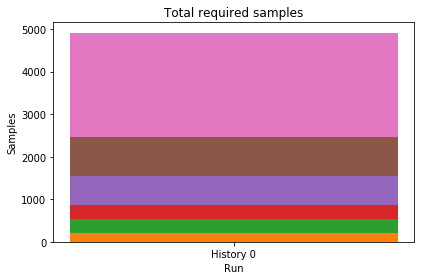

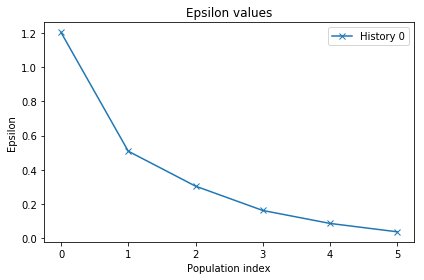

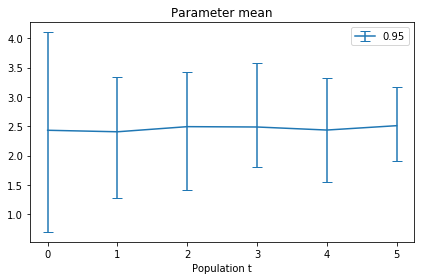

In [10]:
pyabc.visualization.plot_sample_numbers(history)
pyabc.visualization.plot_epsilons(history)
pyabc.visualization.plot_confidence_intervals(history)

That's it. Now you can go ahead and try more sophisticated models.